# CA4

### Imports

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

### Reading data

In [26]:
df = pd.read_csv("./assets/train.csv", index_col = 0)

### Data exploration and visualisation

In [27]:
df.describe()

alpha         delta  ...           MJD      fiber_ID
count  80000.000000  80000.000000  ...  80000.000000  80000.000000
mean     177.579220     24.132590  ...  55587.191400    448.887437
std       96.409584     19.650113  ...   1809.144282    272.328619
min        0.005528    -18.785328  ...  51608.000000      1.000000
25%      127.643892      5.170723  ...  54233.000000    221.000000
50%      180.761747     23.603480  ...  55868.000000    432.000000
75%      233.815698     39.904905  ...  56777.000000    644.000000
max      359.999615     83.000519  ...  58932.000000   1000.000000

[8 rows x 16 columns]

In [28]:
# Checking data types
print(df.dtypes)

alpha          float64
delta          float64
u              float64
g              float64
r              float64
i              float64
z              float64
run_ID           int64
rerun_ID         int64
cam_col          int64
field_ID         int64
spec_obj_ID    float64
class           object
redshift       float64
plate            int64
MJD              int64
fiber_ID         int64
dtype: object


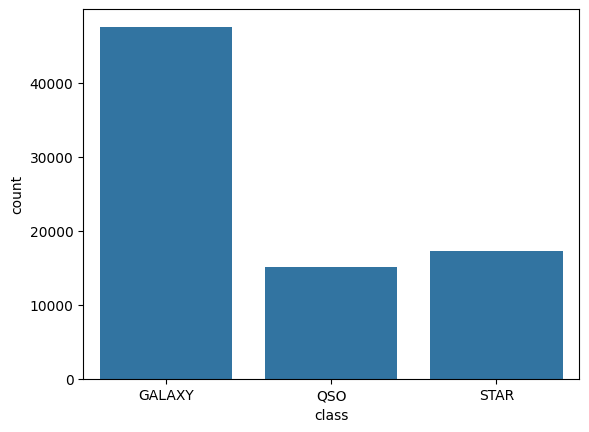

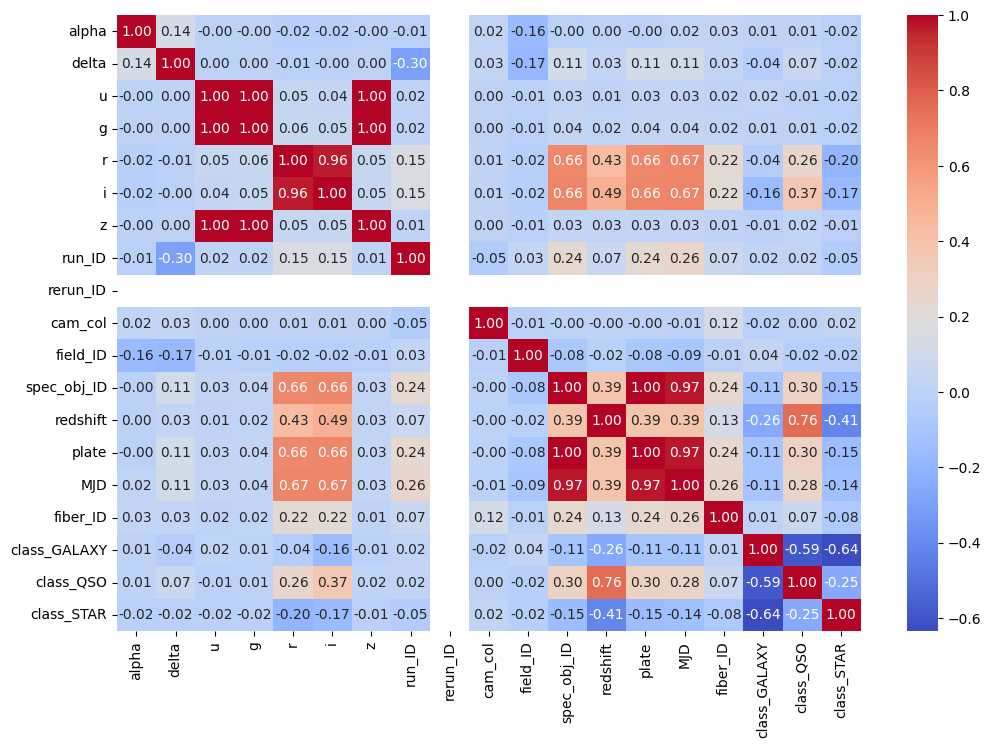

In [ ]:
sns.countplot(x = df["class"])
plt.show()

# Doing classes to numbers so we can explore more, using onehotencoder since the class in nominal.
df_decoded = pd.get_dummies(df, columns = ["class"], dtype = int)

plt.figure(figsize = (12, 8))
sns.heatmap(df_decoded.corr(), annot = True, cmap = "coolwarm", fmt = ".2f")
plt.show()

In [30]:
# Checking dimensions
print(df.shape)


(80000, 17)


##### Conclusion
There is a noticeable imbalance in the dataset,  
with a significantly higher number of galaxy observations compared to other types of stellar objects.  
This imbalance may introduce bias in the analysis and should be taken into consideration.  
In addition, we are working with a huge dataset. We should therefore use Stratified K-Fold as a Cross Validation  
  
Such uneven distribution can also influence the choice of models.  
like Logistic Regression, Decision Trees,  
and Support Vector Classifiers (SVC) may have difficulty performing well under these conditions.  
We will still try out SVC.  

The heatmap indicates complex correlations among several features.  
There is a perfect positive correlation between the variables:  
u and z, g and z, and g and u.  
A strong positive correlation is also observed between i and r.  
In addition, strong positive relationships are found between MJD and spec_obj_ID, and between MJD and plate.  
Spec_obj_ID and plate show a perfect positive correlation as well.  
Lastly, there is a strong negative correlation among the different target classes.


### Data cleaning

In [31]:
print("missing values: \n", df.isnull().sum())
print("\nduplicates: \n", df[df.duplicated()].sum())


missing values: 
 alpha            0
delta            0
u              362
g                0
r                0
i                0
z                0
run_ID           0
rerun_ID         0
cam_col          0
field_ID         0
spec_obj_ID      0
class            0
redshift         0
plate            0
MJD              0
fiber_ID         0
dtype: int64

duplicates: 
 alpha          0.0
delta          0.0
u              0.0
g              0.0
r              0.0
i              0.0
z              0.0
run_ID           0
rerun_ID         0
cam_col          0
field_ID         0
spec_obj_ID    0.0
class            0
redshift       0.0
plate            0
MJD              0
fiber_ID         0
dtype: object


In [32]:
# Dropping missing values
df = df.dropna()

print(f"Shape: {df.shape}")

Shape: (79638, 17)


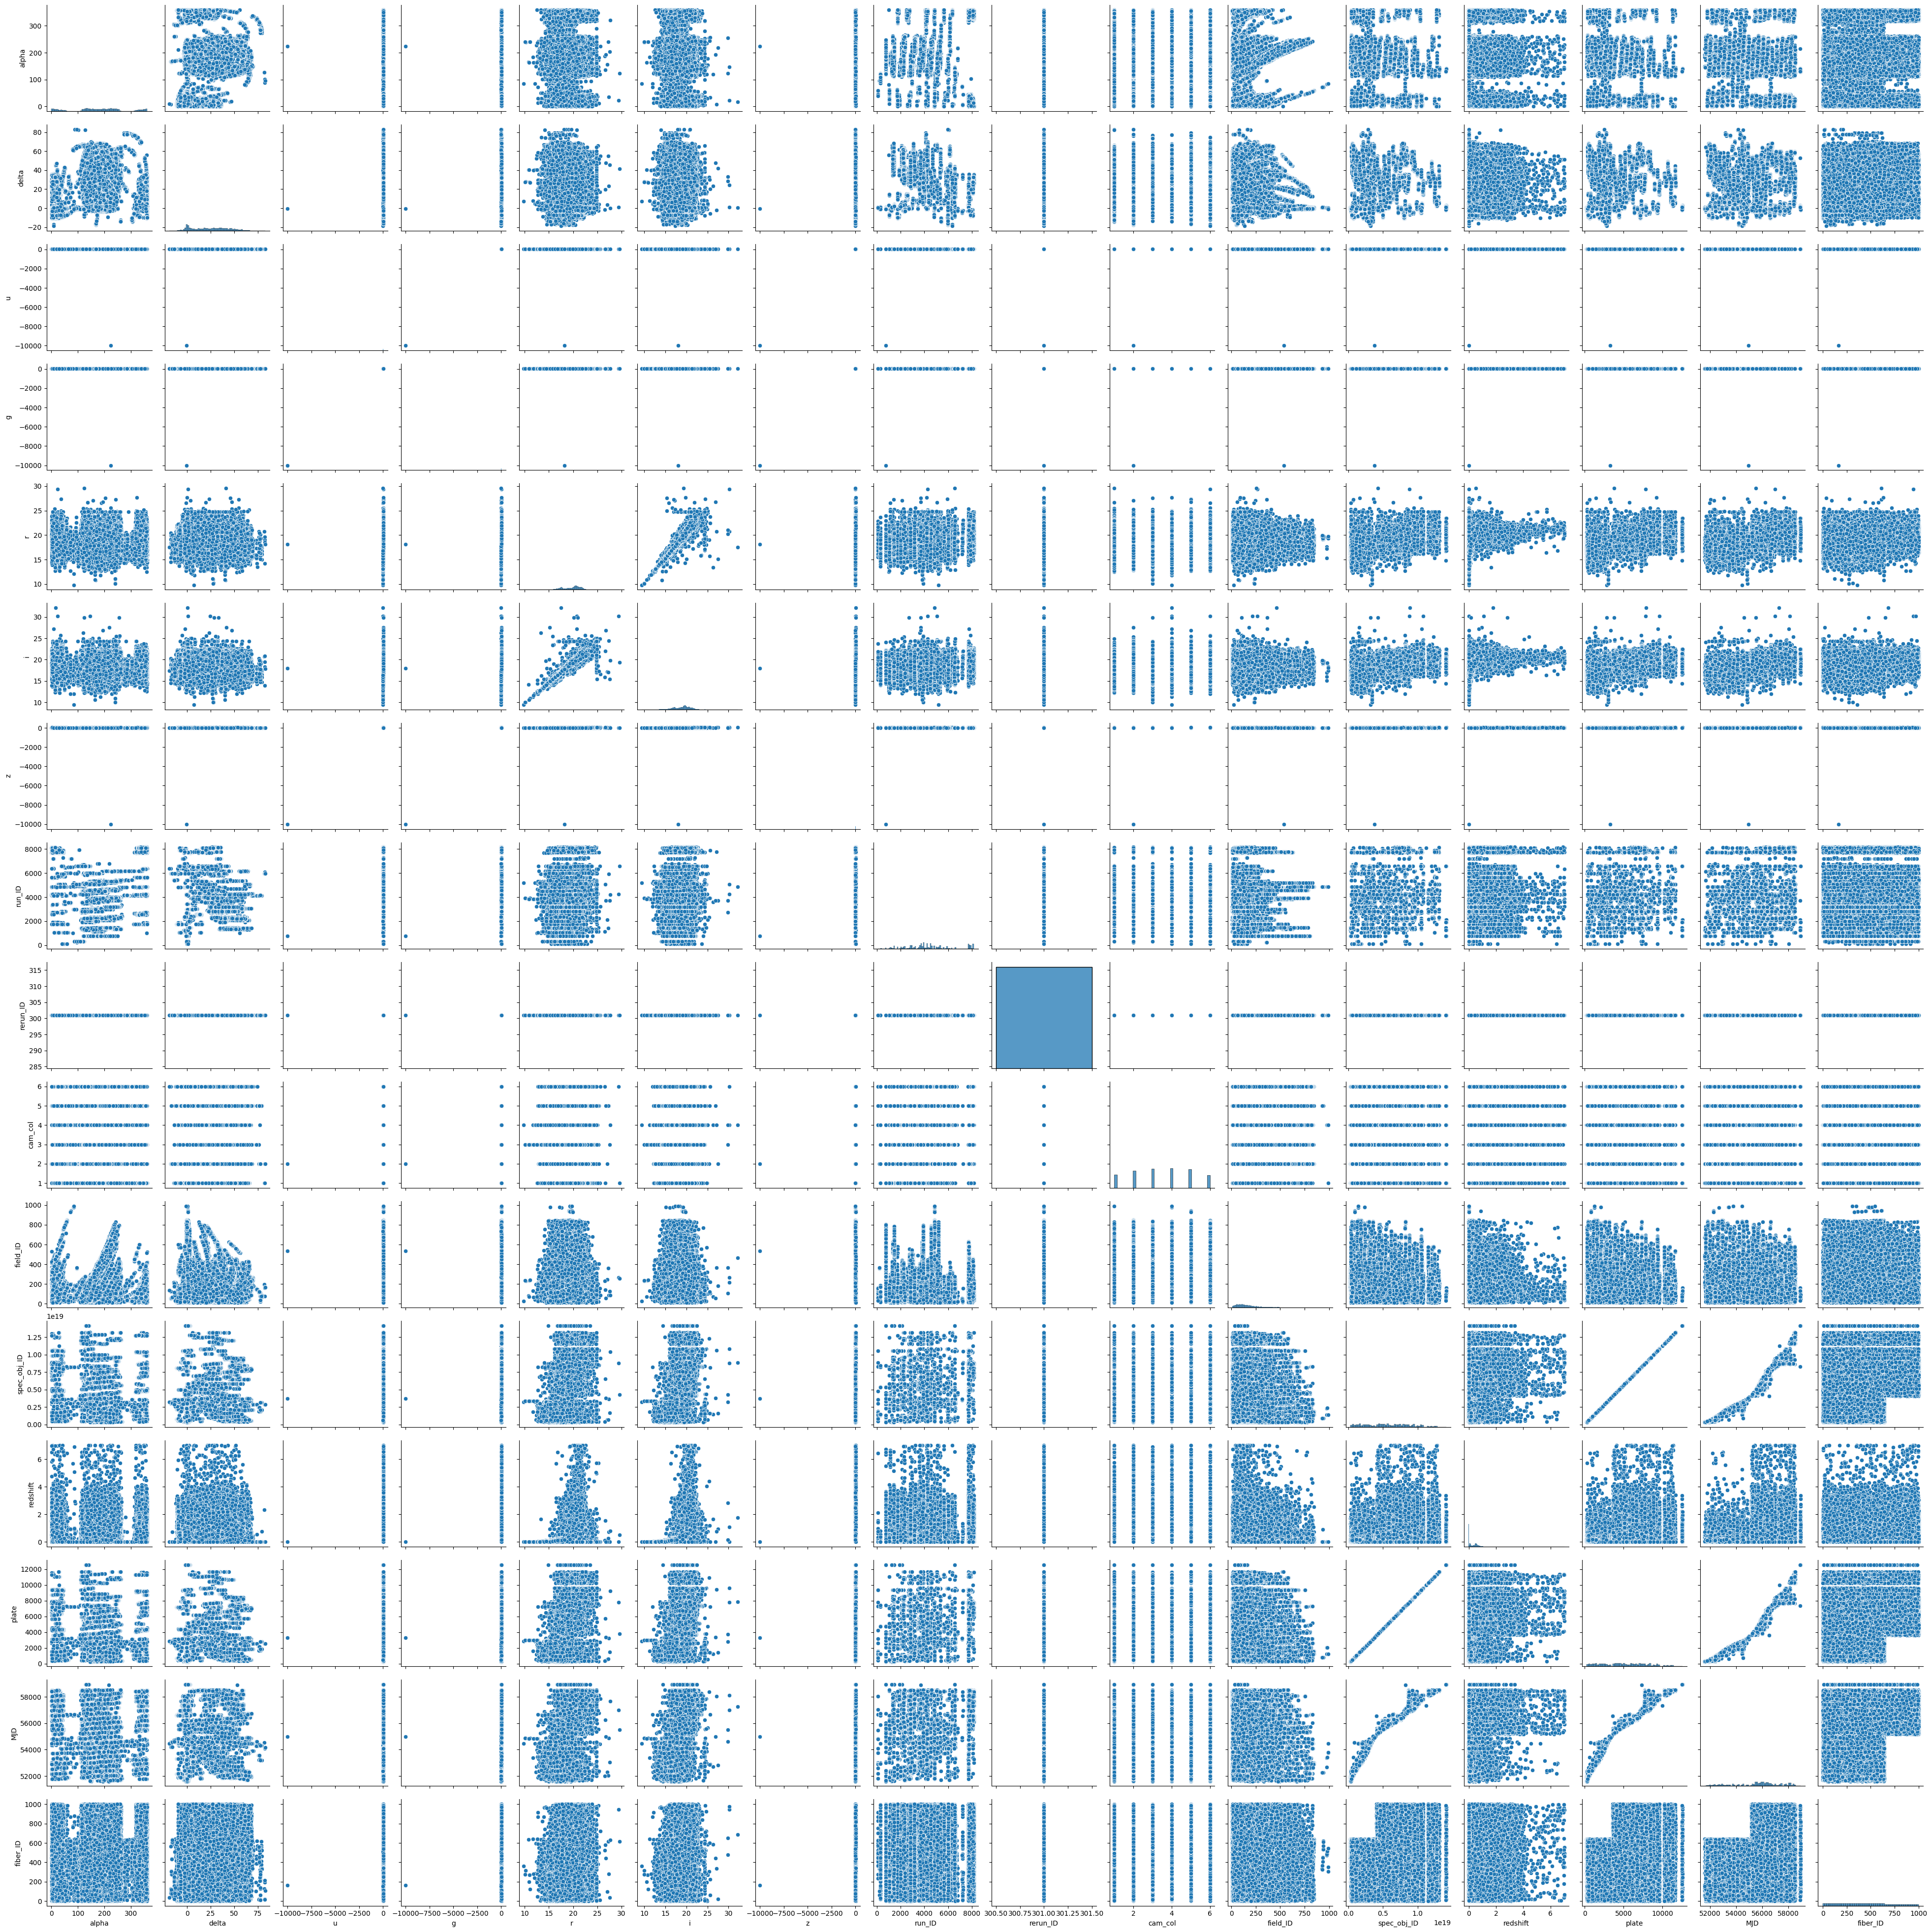

In [33]:
# We want to see the visualize the complex patterns
sns.pairplot(df)
plt.show()

In [41]:
# Splitting Data
X = df.drop(columns = ["class"])
y = df["class"]

PCA could help us with noice and dimention reduction

### Data preprocessing and visualisation

In [ ]:
# Creating Pipelines, 
RFC = Pipeline([
    ("lda", LDA()),
    ("clf", RandomForestClassifier(random_state = 42))
])


svc = SVC(kernel="rbf")
SVM = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components = 0.995)),     # To keep the 99.5% variance
    ("svc", svc)
])



### Modelling

In [52]:
# Grid Search with cross-validation, StritifiedKFold because of the large dataset and the imbalance.
def grid_search(pipeline, param_grid):
    gs = GridSearchCV(estimator = pipeline, 
                      param_grid = param_grid, 
                      scoring = 'f1_macro', 
                      cv = StratifiedKFold(n_splits = 2), 
                      n_jobs = -1)
    
    gs.fit(X, y)
    print("CV: DONE")
    
    y_pred = gs.predict(X)
    score = f1_score(y, y_pred, average = 'macro')
    print("F1 Macro:", score)

    return gs
    

In [53]:
# Random Forest, parts of the code is taken from Chapter_6_part_2a.ipynb from Canvas
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
}

gs_RFC = grid_search(RFC, param_grid)

CV: DONE
F1 Macro: 0.916249843887992


In [70]:
# SVC
param_grid = {
    'svc__C': [1, 10, 100],
    'svc__gamma': ['scale', 0.01, 0.001],
}

gs_SVC = grid_search(SVM, param_grid)

CV: DONE
F1 Macro: 0.9592984259200682


### Final evaluation

In [71]:
# Looking at the best models parameters
model = gs_SVC.best_estimator_
print(gs_SVC.best_params_)

cv_scores = cross_val_score(model, X, y, cv = 5, scoring = 'f1_macro')
print("Mean CV F1-macro:", np.mean(cv_scores))

{'svc__C': 100, 'svc__gamma': 0.01}
Mean CV F1-macro: 0.9585605242136388


F1-macro: 0.9602166213283221 

              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.97     19018
         QSO       0.97      0.89      0.93      5896
        STAR       0.97      1.00      0.98      6942

    accuracy                           0.97     31856
   macro avg       0.97      0.96      0.96     31856
weighted avg       0.97      0.97      0.97     31856



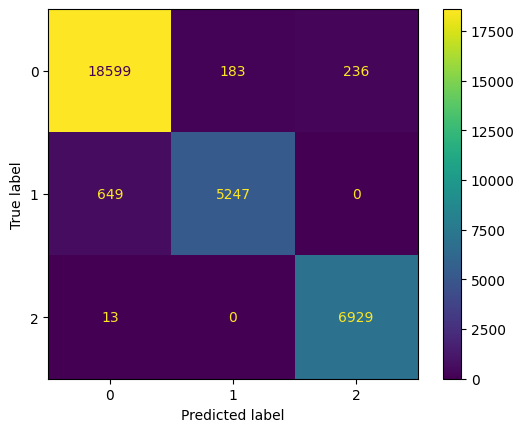

In [72]:
# Confusion Matrix & F1 Evaluation
X_train60, X_test40, y_train60, y_test40 = train_test_split(X, y, test_size = 0.4, random_state = 42)
y_pred = model.predict(X_test40)

cm = confusion_matrix(y_test40, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

print(f"F1-macro: {f1_score(y_test40, y_pred, average = 'macro')} \n")
print(classification_report(y_test40, y_pred))

### Kaggle submission

In [73]:
df_test = pd.read_csv("./assets/test.csv", index_col = 0)

submission = model.predict(df_test)
submission = pd.DataFrame(submission, columns = ["class"])
submission.index.name = "ID"

label_map = {"GALAXY": 0, "QSO": 1, "STAR": 2}
submission["class"] = submission["class"].map(label_map)

submission[["class"]].to_csv("submission.csv")